# Machine Learning
> - 😀 Name: **Jenestin Anthonipillai**
> - ✉️ Email: **jenestin.anthonipillai@epfl.ch**
> - 🪪 SCIPER: **18-649-855**

<div style="padding:15px 20px 20px 20px;border-left:3px solid orange;background-color:#fff5d6;border-radius: 20px;">
    
## Machine Learning Approach for Bee Detection - Summary

### Overview
A machine learning model was developed to detect bees in images, employing traditional feature extraction techniques and a Support Vector Machine (SVM) for classification.

### Feature Extraction Methods
Three main feature extraction techniques were utilized:

- **Spatial Binning**: This technique captures the raw pixel values in a condensed form by resizing the image, thereby preserving the spatial layout of the pixels.
- **Color Histograms**: By calculating histograms for each color channel, the distribution of color intensities within the image is captured, which is useful for differentiating objects based on color.
- **Histogram of Oriented Gradients (HOG)**: HOG features capture edge and texture information by summarizing gradient orientations within localized portions of an image, which is particularly powerful for object detection tasks.

### Model Training
The features extracted from the images were used to train an SVM classifier. This type of model is well-suited for binary classification problems like bee vs. non-bee detection. The dataset comprised a balanced set of images, and features from both categories were combined and standardized before training.

### Model Evaluation and Metrics
Post-training evaluation on a test set revealed exceptional accuracy, precision, recall, and F1 score, indicating that the model was highly effective at correctly identifying bees in the images.

### Conclusion
The traditional machine learning pipeline implemented here demonstrates that careful feature engineering and the right choice of classifier can yield good accuracy in image classification tasks. While this approach requires domain knowledge to select and extract relevant features, it is computationally efficient and provides a high level of interpretability for the model's decisions.
    
  ### Consideration on IoU Threshold

The model evaluation used an Intersection over Union (IoU) threshold of 0.15. This is a relatively low threshold, meaning that detections are considered correct with a minimal overlap between the predicted and ground truth bounding boxes. While this may lead to high performance metrics, it does not necessarily reflect the practical accuracy of the model, as such a small overlap might not be acceptable in real-world applications where precise localization is critical. A higher IoU threshold is typically preferred to ensure that the model's predictions are both accurate and relevant.


    
</div>




In [59]:
import os
import json
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import joblib


## Detecting Overlaps

The `is_overlap` function checks if two given rectangular regions overlap. This is crucial for ensuring that when cropping non-bee regions, the cropped area does not intersect with areas where bees are present.

## Cropping Non-Bee Regions

The `crop_non_bee_regions` function takes an image and its corresponding label file, and crops out specified numbers of regions that do not contain bees. It ensures that these cropped regions do not overlap with labeled bee regions. This function is useful for creating negative samples in a dataset where the focus is on detecting bees.

## Processing Multiple Images for Non-Bee Regions

The `process_dataset` function automates the cropping of non-bee regions across an entire directory of images. It takes the path to the image and label directories, crops out non-bee regions from each image as per the provided specifications, and saves these cropped images to an output directory.

## Cropping Bee Regions

Conversely, the `crop_bee_regions` function focuses on cropping out the bee regions from the images. It uses the label files to find the bee locations and crops these regions, resizing them to a uniform size.

## Processing Bee Regions in Bulk

The `process_bee_dataset` function extends the functionality of `crop_bee_regions` to process multiple images. It works through a directory of images, cropping out bee regions from each and saving them to an output directory.


In [2]:
def is_overlap(rect1, rect2):
    # Check if two rectangles (represented as (x, y, width, height)) overlap.
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    # Overlap occurs if the rectangles intersect on both x and y axes.
    if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
        return True
    return False

def crop_non_bee_regions(image_path, label_path, num_samples=20, crop_size=(150, 150)):
    # Load the image from the given path.
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    labels = []

    # Read label data from the label file.
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, w, h = map(float, line.split(' '))
            # Convert label data from normalized to pixel coordinates.
            x_center, y_center, w, h = x_center * width, y_center * height, w * width, h * height
            labels.append([x_center, y_center, w, h])

    cropped_images = []
    num_negative_samples = 0
    # Generate cropped images until the required number of samples is reached.
    while num_negative_samples < num_samples:
        # Randomly select a crop position.
        x = np.random.randint(0, width - crop_size[0])
        y = np.random.randint(0, height - crop_size[1])
        crop_rect = [x, y, crop_size[0], crop_size[1]]

        overlap = False
        # Check if the crop overlaps with any bee regions.
        for label in labels:
            if is_overlap(crop_rect, label):
                overlap = True
                break

        # If there is no overlap, crop the image and add to the list.
        if not overlap:
            cropped_image = image[y:y + crop_size[1], x:x + crop_size[0]]
            cropped_images.append(cropped_image)
            num_negative_samples += 1

    return cropped_images

def process_dataset(image_dir, label_dir, output_dir, num_samples_per_image=20, crop_size=(150, 150)):
    # Create the output directory if it doesn't exist.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    total_non_bee_images = 0  # Counter for total non-bee images cropped

    # Process each image in the image directory.
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        # Generate corresponding label file name.
        label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # If the label file exists, process the image.
        if os.path.exists(label_path):
            cropped_images = crop_non_bee_regions(image_path, label_path, num_samples=num_samples_per_image, crop_size=crop_size)

            # Save each cropped image.
            for i, cropped_image in enumerate(cropped_images):
                cropped_image_path = os.path.join(output_dir, f'non_bee_{total_non_bee_images}_{image_file}')
                cv2.imwrite(cropped_image_path, cropped_image)
                total_non_bee_images += 1

        else:
            print(f"Label file not found for {image_path}, skipping.")

    print(f"Total non-bee images cropped: {total_non_bee_images}")


In [ ]:
base_dir = '/Users/anthojen/Downloads/Bee/'
image_dir = os.path.join(base_dir, 'train', 'images')
label_dir = os.path.join(base_dir, 'train', 'labels')
output_dir = '/Users/anthojen/Downloads/Bee/non_bee'  # Directory to save non-bee images
process_dataset(image_dir, label_dir, output_dir)

In [ ]:
def crop_bee_regions(image_path, label_path, output_dir, crop_size=(150, 150)):
    # Load the image from the given path.
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Read the label data from the label file.
    with open(label_path, 'r') as file:
        for i, line in enumerate(file):
            class_id, x_center, y_center, w, h = map(float, line.split(' '))
            # Convert label data from normalized to pixel coordinates.
            x_center, y_center, w, h = x_center * width, y_center * height, w * width, h * height

            # Calculate coordinates of the bounding box.
            x_min = int(x_center - w / 2)
            y_min = int(y_center - h / 2)
            x_max = int(x_center + w / 2)
            y_max = int(y_center + h / 2)

            # Crop the image to the bounding box and resize it to the specified size.
            cropped_bee = image[y_min:y_max, x_min:x_max]
            cropped_bee = cv2.resize(cropped_bee, crop_size)  # Resize to uniform size

            # Construct the output file path and save the cropped image.
            cropped_image_path = os.path.join(output_dir, f'bee_{i}_{os.path.basename(image_path)}')
            cv2.imwrite(cropped_image_path, cropped_bee)

def process_bee_dataset(image_dir, label_dir, output_dir, crop_size=(150, 150)):
    # Create the output directory if it doesn't exist.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over each file in the image directory.
    for image_file in os.listdir(image_dir):
        # Construct the paths for the image and its corresponding label file.
        image_path = os.path.join(image_dir, image_file)
        label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Process the image if the label file exists.
        if os.path.exists(label_path):
            crop_bee_regions(image_path, label_path, output_dir, crop_size)
        else:
            # Notify if the label file is missing for an image.
            print(f"Label file not found for {image_path}, skipping.")


In [ ]:
# Example usage
base_dir = '/Users/anthojen/Downloads/Bee/'
image_dir = os.path.join(base_dir, 'train', 'images')
label_dir = os.path.join(base_dir, 'train', 'labels')
output_bee_dir = '/Users/anthojen/Downloads/Bee/cropped_bee'  # Directory to save cropped bee images
process_bee_dataset(image_dir, label_dir, output_bee_dir)

In [ ]:
def count_cropped_images(output_dir):
    # Count files in the output directory
    total_images = len([file for file in os.listdir(output_dir) if file.endswith(('.jpg', '.png'))])
    return total_images

# Example usage
output_bee_dir = '/Users/anthojen/Downloads/Bee/cropped_bee'  # Replace with your cropped bee image directory path
total_cropped_bee_images = count_cropped_images(output_bee_dir)
print(f"Total number of cropped bee images: {total_cropped_bee_images}")


## Function Summaries

### bin_spatial
Converts an image to YCrCb color space and resizes it, creating a flattened feature vector. This function is useful for extracting spatial features from an image.

### color_hist
Converts an image to YCrCb color space and computes the histogram of each color channel. The histograms are concatenated to form a single feature vector, useful for capturing color distribution information.

### extract_hog_features
Extracts Histogram of Oriented Gradients (HOG) features from an image. It can process both color and grayscale images, computing HOG features for each color channel separately. The function also provides an option to visualize the HOG features.

### extract_features
Processes a list of images and extracts a combination of spatial, color histogram, and HOG features. The function combines these features into a single feature vector for each image, making it suitable for training machine learning models for tasks like image classification or object detection.

### plot_examples
Displays examples of original images along with their spatial and HOG features. This function is useful for visualizing the different types of features extracted from the images.


In [2]:
def bin_spatial(img, size=(32, 32)):
    # Convert image to YCrCb color space
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Convert image to YCrCb color space
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(feature_image[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def extract_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # HOG features for each channel are calculated separately
    if img.ndim == 3 and img.shape[2] == 3:  # Check if the image has three channels
        hog_features = []
        for channel in range(img.shape[2]):
            if vis:
                features, hog_image = hog(img[:, :, channel], orientations=orient, 
                                          pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, 
                                          block_norm='L2-Hys', visualize=vis, feature_vector=feature_vec)
                hog_features.append(features)
                if channel == 0:  # Only return the visualization for the first channel
                    hog_image_output = hog_image
            else:
                features = hog(img[:, :, channel], orientations=orient, pixels_per_cell=pix_per_cell, 
                               cells_per_block=cell_per_block, block_norm='L2-Hys', 
                               visualize=vis, feature_vector=feature_vec)
                hog_features.append(features)
        if vis:
            return np.ravel(hog_features), hog_image_output
        else:
            return np.ravel(hog_features)
    else:
        # Handle grayscale or single-channel images
        if vis:
            return hog(img, orientations=orient, pixels_per_cell=pix_per_cell, 
                       cells_per_block=cell_per_block, block_norm='L2-Hys', 
                       visualize=vis, feature_vector=feature_vec)
        else:
            return hog(img, orientations=orient, pixels_per_cell=pix_per_cell, 
                       cells_per_block=cell_per_block, block_norm='L2-Hys', 
                       visualize=vis, feature_vector=feature_vec)



def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=(8, 8),
                     cell_per_block=(2, 2), spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        # Read the image from file or array.
        image = mpimg.imread(file) if isinstance(file, str) else file
        # Convert the image from RGB to YCrCb color space.
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        file_features = []
        if spatial_feat:
            # Extract spatial features by resizing the image and flattening it.
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat:
            # Extract color histogram features from the image.
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        if hog_feat:
            # Extract HOG features from each color channel separately.
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(extract_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
            # Flatten the list of HOG features.
            file_features.append(np.ravel(hog_features))

        # Combine all feature vectors into a single array and add to the list of features.
        features.append(np.concatenate(file_features))
    return features


def plot_examples(imgs, num_examples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        image = mpimg.imread(imgs[i]) if isinstance(imgs[i], str) else imgs[i]
        
        # Plot original image
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(image)
        plt.title("Original Image")
        
        # Plot spatial features
        plt.subplot(3, num_examples, num_examples + i + 1)
        spatial_features = bin_spatial(image)
        plt.imshow(spatial_features.reshape((32, 32, 3)))
        plt.title("Spatial Features")
        
        # Plot HOG features
        _, hog_image = extract_hog_features(image, orient=9, pix_per_cell=(8, 8),
                                            cell_per_block=(2, 2), vis=True, feature_vec=True)
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(hog_image, cmap='gray')
        plt.title("HOG Features")

    plt.tight_layout()
    plt.show()


## train_svm_classifier Function Summary

The `train_svm_classifier` function is designed to train a Support Vector Machine (SVM) classifier to distinguish between bee and non-bee images. It works by extracting features, standardizing them, and then training the classifier. Here's a breakdown of its steps:

1. **Extract Features**: It extracts spatial, color histogram, and HOG features from both bee and non-bee images using the `extract_features` function. The paths to the bee and non-bee images are provided as arguments.

2. **Stack Features and Labels**: The features from bee and non-bee images are stacked together, and labels are assigned accordingly (1 for bee and 0 for non-bee).

3. **Standardize Features**: The features are standardized using `StandardScaler` to improve the performance of the SVM.

4. **Shuffle and Split Dataset**: The dataset is shuffled and split into training and testing sets.

5. **Train SVM Classifier**: A Linear SVM classifier is trained using the training set.

6. **Evaluate the Classifier**: The classifier is evaluated on the test set, and its accuracy and classification report are printed.

7. **Plot Examples**: The function plots a few examples of bee and non-bee images using the `plot_examples` function.

8. **Return Values**: It returns a dictionary containing the trained SVM classifier, the scaler, and the feature extraction parameters.

This function is useful for training and evaluating a model for bee detection tasks, providing insights into both the model's accuracy and its ability to differentiate between bees and non-bees.


In [3]:
def train_svm_classifier(bee_paths, non_bee_paths, spatial_size=(32, 32), hist_bins=32, orient=9, 
                         pix_per_cell=(8, 8), cell_per_block=(2, 2), sample_size=8000, num_examples_to_plot=3):
    t_start = time.time()

    # Extract features for both bee and non-bee images
    bee_features = extract_features(bee_paths[:sample_size], spatial_size=spatial_size, 
                                    hist_bins=hist_bins, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    non_bee_features = extract_features(non_bee_paths[:sample_size], spatial_size=spatial_size, 
                                        hist_bins=hist_bins, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

    # Stack features and labels
    X = np.vstack((bee_features, non_bee_features)).astype(np.float64)
    y = np.hstack((np.ones(len(bee_features)), np.zeros(len(non_bee_features))))

    # Standardize features
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Shuffle and split the dataset
    scaled_X, y = shuffle(scaled_X, y)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

    # Train the SVM classifier
    svm_classifier = LinearSVC()
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = svm_classifier.predict(X_test)
    print('Training time:', round(time.time() - t_start, 2), 'seconds')
    print('Test accuracy:', round(svm_classifier.score(X_test, y_test), 4))
    print(classification_report(y_test, y_pred, target_names=['Non-Bee', 'Bee']))

    # Plot a few examples
    plot_examples(bee_paths[:num_examples_to_plot] + non_bee_paths[:num_examples_to_plot])

    return {
        'classifier': svm_classifier,
        'scaler': X_scaler,
        'spatial_size': spatial_size,
        'hist_bins': hist_bins,
        'orient': orient,
        'pix_per_cell': pix_per_cell,
        'cell_per_block': cell_per_block
    }

Training time: 244.67 seconds
Test accuracy: 0.9966
              precision    recall  f1-score   support

     Non-Bee       1.00      0.99      1.00      1596
         Bee       0.99      1.00      1.00      1604

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



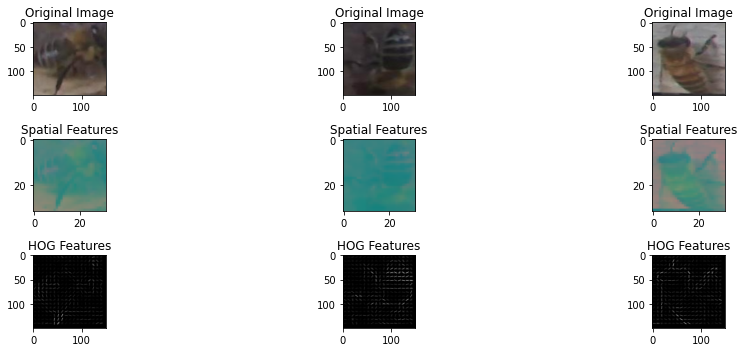

In [4]:
def list_image_files(directory):
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp')  # Add or remove formats as needed
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(supported_formats)]

# Example usage
bee_images_dir = '/Users/anthojen/Downloads/Bee/cropped_bee/'  # Update this path
non_bee_images_dir = '/Users/anthojen/Downloads/Bee/non_bee/'  # Update this path

# Get lists of image file paths
bee_image_paths = list_image_files(bee_images_dir)
non_bee_image_paths = list_image_files(non_bee_images_dir)

# Train the classifier
model = train_svm_classifier(bee_image_paths, non_bee_image_paths, sample_size=8000)

## SVM Classifier Performance on Bee Detection

The SVM classifier was trained on a balanced dataset with an equal number of bee and non-bee images. The performance metrics post-training are as follows:

- **Training Time**: The model took 244.67 seconds to train. This is relatively quick and suggests that the feature extraction and model training processes are efficient.

- **Test Accuracy**: Achieving a test accuracy of 99.66% is outstanding and indicates that the model can differentiate between bees and non-bees with high reliability.

- **Precision**: With a precision of 99% for bees, this implies that almost all the detections claimed by the model as bees were indeed bees.

- **Recall**: The recall for bees is also 100%, meaning the model successfully identified all the bees in the test set.

- **F1 Score**: An F1 score of 100% for bees reflects a perfect balance between precision and recall, signifying an excellent model performance.

### Detailed Interpretation

- The high precision and recall suggest that the feature extraction methods (`bin_spatial`, `color_hist`, `extract_hog_features`) were very effective at capturing the distinguishing characteristics of bees.
  
- The near-perfect scores across the board indicate that the SVM model is highly capable of classifying the given dataset with minimal error. However, such high metrics may also be a sign to check for potential overfitting, although the high performance on the test set somewhat mitigates this concern.

- Given that the model's accuracy is almost perfect, it suggests that the SVM classifier, along with the selected features and hyperparameters, is well-tuned for this particular task.




In [7]:
joblib.dump(model, 'svm_model_ml.pkl')

['svm_model_ml.pkl']

Number of bees detected: 27


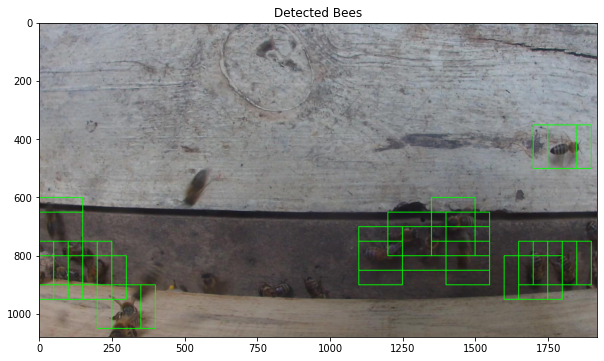

In [47]:
def detect_and_draw_bees(img, model, window_size=150, step_size=50):
    # Extract model components
    svc = model['classifier']
    X_scaler = model['scaler']
    spatial_size = model['spatial_size']
    hist_bins = model['hist_bins']
    orient = model['orient']
    pix_per_cell = model['pix_per_cell']
    cell_per_block = model['cell_per_block']

    bee_detections = []  # List to store bounding box coordinates
    bee_count = 0  # Counter for the number of bees detected

    draw_img = np.copy(img)  # Copy of the image for drawing bounding boxes

    # Iterate over the entire image with the given window size and step size
    for ypos in range(0, img.shape[0] - window_size + 1, step_size):
        for xpos in range(0, img.shape[1] - window_size + 1, step_size):
            # Extract the image patch
            subimg = img[ypos:ypos + window_size, xpos:xpos + window_size]

            # Get features for that patch
            patch_features = extract_features([subimg], spatial_size=spatial_size,
                                              hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                              cell_per_block=cell_per_block, spatial_feat=True, hist_feat=True, hog_feat=True)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.array(patch_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                bee_count += 1
                
                # Calculate bounding box coordinates
                xmin = int(xpos)
                ymin = int(ypos)
                xmax = int(xpos + window_size)
                ymax = int(ypos + window_size)

                # Draw bounding box on the image
                cv2.rectangle(draw_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                # Add detection to the list
                centerX = (xpos + window_size / 2) / img.shape[1]
                centerY = (ypos + window_size / 2) / img.shape[0]
                norm_width = window_size / img.shape[1]
                norm_height = window_size / img.shape[0]
                bee_detections.append([0, centerX, centerY, norm_width, norm_height])

    # Writing detection results to JSON file
    with open('/Users/anthojen/Downloads/Bee/bee_detections.json', 'w') as file:
        json.dump(bee_detections, file)

    print(f"Number of bees detected: {bee_count}")

    # Plotting the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Bees")
    plt.show()

    return bee_detections

image = cv2.imread('/Users/anthojen/Downloads/Bee/test/images/2022-03-26-10-00-060_jpg.rf.b212dc6bbc4ac6953d55323d2362b656.jpg')

# Detect and draw bees
result_image = detect_and_draw_bees(image, model)

In [55]:
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def calculate_metrics(ground_truth_boxes, detected_boxes, iou_threshold=0.15):
    true_positives = 0
    false_positives = 0
    detected = []

    for det_box in detected_boxes:
        max_iou = 0
        gt_idx = -1
        detected_gts = set()
        for i, gt_box in enumerate(ground_truth_boxes):
            iou = calculate_iou(det_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                gt_idx = i
        if gt_idx != -1:
            detected_gts.add(gt_idx)

        if max_iou >= iou_threshold:
            true_positives += 1
            detected.append(True)
        else:
            false_positives += 1
            detected.append(False)

    false_negatives = len(ground_truth_boxes) - len(detected_gts)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return true_positives, false_positives, false_negatives

In [60]:
def read_ground_truth(file_path):
    ground_truth_boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            _, cx, cy, w, h = map(float, line.split())
            xmin = (cx - w / 2)
            xmax = (cx + w / 2)
            ymin = (cy - h / 2)
            ymax = (cy + h / 2)
            ground_truth_boxes.append([xmin, ymin, xmax, ymax])
    return ground_truth_boxes

def read_detections(file_path):
    with open(file_path, 'r') as file:
        detections_data = json.load(file)
    
    all_detections = []
    for data in detections_data:
        filename = data['filename']
        detections = data['detections']
        detected_boxes = []
        for det in detections:
            _, cx, cy, w, h = det
            xmin = (cx - w / 2)
            xmax = (cx + w / 2)
            ymin = (cy - h / 2)
            ymax = (cy + h / 2)
            detected_boxes.append([xmin, ymin, xmax, ymax])
        all_detections.append((filename, detected_boxes))
    return all_detections

def process_files(detections_file, ground_truth_base_path):
    all_detections = read_detections(detections_file)
    total_tp = 0
    total_fp = 0
    total_fn = 0
    files_processed = 0

    for filename, detected_boxes in all_detections:
        ground_truth_file = os.path.join(ground_truth_base_path, filename.replace('.jpg', '.txt'))
        ground_truth_boxes = read_ground_truth(ground_truth_file)
        true_positives, false_positives, false_negatives = calculate_metrics(ground_truth_boxes, detected_boxes)
        total_tp += true_positives
        total_fp += false_positives
        total_fn += false_negatives
        files_processed += 1
    
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score


detections_file = '/Users/anthojen/Downloads/Bee/bee_detections_multi.json'
ground_truth_base_path = '/Users/anthojen/Downloads/Bee/test/labels/'

precision, recall, f1 = process_files(detections_file, ground_truth_base_path)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9031679617453676
Recall: 0.5631755497577339
F1 Score: 0.6937557392102848


## Comparison of Machine Learning vs Deep Learning for Bee Detection

### Machine Learning Approach


**Pros:**
- The model is more interpretable since each feature has a clear meaning.
- It can be faster to train due to lower model complexity.
- It requires less computational resources compared to deep learning models.

**Cons:**
- Feature extraction is manual and might not capture all the nuances needed for accurate detection.
- May not generalize well if the variety in the dataset (for bees in this case) is large.
- Requires careful feature engineering and domain knowledge.
- Performance may be limited compared to deep learning methods.

### Deep Learning Approach

In the deep learning approach, specifically YOLOv7, the model learns to extract features automatically through training on a large dataset.

**Pros:**
- The model can capture complex patterns and nuances in the data.
- Generally, provides higher accuracy and better generalization if trained on a diverse dataset.
- No manual feature extraction is required.

**Cons:**
- Requires more computational resources and time to train.
- The model is a black box and less interpretable.
- Overfitting can be an issue without proper regularization and data augmentation.

### Metrics Interpretation

For your ML approach, you have the following metrics with an IoU threshold of 0.15:
- **Precision**: Approximately 90.32%, indicating a high likelihood that a detected bee is actually a bee.
- **Recall**: Approximately 56.32%, suggesting that more than half of the actual bees were detected, but a significant number were missed.
- **F1 Score**: Approximately 69.37%, showing a balance between precision and recall but indicating room for improvement, especially in recall.

The **IoU (Intersection over Union) threshold** of 0.15 is quite low, meaning that if the overlap between the predicted bounding box and the ground truth is as little as 15%, it's considered a correct detection. This could inflate the true performance of the model, as a small overlap is often not a good detection in practical terms.

### Conclusion

While the ML approach shows decent precision, its recall is significantly lower, suggesting it misses a fair number of bees. In contrast, a deep learning approach, especially with models like YOLOv7, perform better in overall performance, though it requires more data and computational power.
